In [1]:
from buildingspy.io.outputfile import Reader
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
import sys
sys.path.insert(0, '/media/maousi/Data/Documents/Programmation/git/vad-0d-dnn/Pre-processing')

In [3]:
import script_createdataset as sc

In [4]:
path = '/media/maousi/Data/tmp/case_study/'
file_ = 'Ursino1998Model_VAD2_AP_{}_RPM_{}_HF_{}.csv'

In [5]:
file = file_.format(True, 5000, 'SHF')

In [6]:
def extract_results(file_path, var):
    df = pd.read_csv(file_path)
    return df.time.values, df[var].values

In [7]:
def reconstruct(aks, bks, t, T):
    x = t * 0 + aks[0] / 2
    for k in range(1, len(aks)):
        x += aks[k] * np.cos(2*np.pi*t * k / T) + \
             bks[k] * np.sin(2*np.pi*t * k / T)
    return x

# Test

## Analytical function

In [8]:
f = lambda x: x * np.exp(-x)

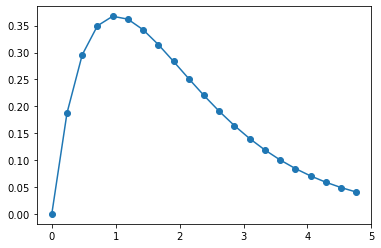

In [9]:
n_samples = 20
T = 5
t = T / (n_samples+1) * np.arange(0, n_samples+1)
signal = f(t)
plt.plot(t, signal, '-o');

In [10]:
_, aks, bks = sc.myfft(signal)

In [11]:
x = reconstruct(aks, bks, t, T)

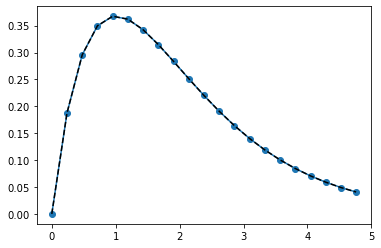

In [12]:
plt.plot(t, x, '-o', t, signal, '--k');

## Model simulation file

In [13]:
model_file = '../Pre-processing/model_file_2.mat'
reader = Reader(model_file, 'dymola')
t, signal = sc.extract_results('SystemicArteries.PC', reader)
t, signal = sc.time_range(signal, t, 20.0, 30.0)

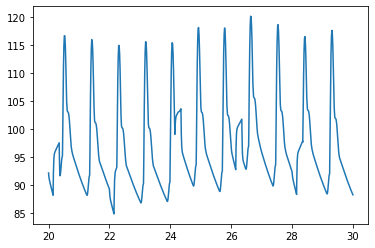

In [14]:
plt.plot(t, signal)

In [15]:
_, aks, bks, T, t, signal = sc.perform_fft(signal, t, 0.015)
signal_tilda = reconstruct(aks, bks, t, T)

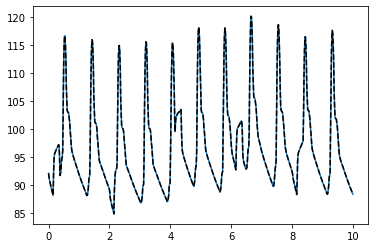

In [16]:
plt.plot(t, signal_tilda, t, signal, '--k');

# Look at case study data

In [17]:
# Determine which cases we examine
cases = [
    (True, 5000, 'MHF'),
    (True, 6000, 'MHF'),
    (True, 4000, 'SHF'),
    (True, 6000, 'SHF')
]

files = [path + file_.format(*case) for case in cases]

In [18]:
file = files[0]
file

'/media/maousi/Data/tmp/case_study/Ursino1998Model_VAD2_AP_True_RPM_5000_HF_MHF.csv'

In [19]:
t, signal = extract_results(file, 'SystemicArteries.Inlet.P')
t, signal = sc.time_range(signal, t, 20.0, 30.0)

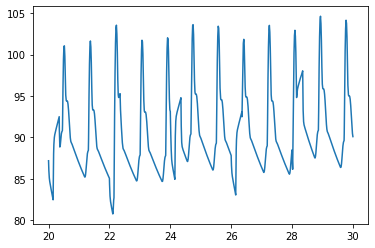

In [20]:
plt.plot(t, signal)

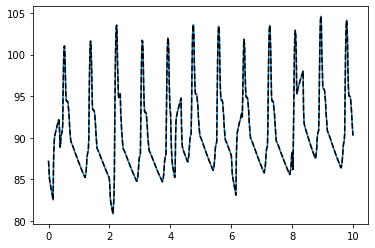

In [21]:
_, aks, bks, T, t, signal = sc.perform_fft(signal, t, 0.015)
signal_tilda = reconstruct(aks, bks, t, T)

plt.plot(t, signal_tilda, t, signal, '--k');

## Compute coefs of case study files

In [22]:
tmin, tmax = 20.0, 30.0
dt = 0.015

In [23]:
# Data structure: dictionnary
# key = case tuple (AP, RPM, HF)
# value = tuple (t, signal, aks, bks, T)
coefs = {}
for case, file in zip(cases, files):
    t, signal = extract_results(file, 'SystemicArteries.Inlet.P')
    t, signal = sc.time_range(signal, t, tmin, tmax)
    _, aks, bks, T, t, signal = sc.perform_fft(signal, t, dt)
    
    coefs[case] = (t, signal, aks, bks, T)

## Reconstruct truncated signal

In [24]:
def reconstruct_truncated(n, aks, bks, t, T):
    return reconstruct(aks[:n], bks[:n], t, T)

## Nice visualization

Idea: N x 3 plot grid, N the number of cases

* Left panel: original signal overlapping with reconstructed signal
* Middle and right panels: aks and bks coeffs

In [25]:
def visualize(coefs_data, n):
    fig, ax = plt.subplots(len(coefs_data), 3, figsize=(20,len(coefs_data)*5))
    
    for row, (case, (t, signal, aks, bks, T)) in enumerate(coefs_data.items()):
        # Plot Fourier coefficients
        ax[row][1].plot(aks[1:n+100])
        ax[row][2].plot(bks[:n+100])
        ax[row][1].axvline(n, color='k')
        ax[row][2].axvline(n, color='k')
        
        # Reconstruct truncated signal
        signal_tilda = reconstruct_truncated(n, aks, bks, t, T)
        # Plot overlapping signals
        ax[row][0].plot(t, signal_tilda, t, signal, '--k')
        
        ax[row][0].set_title(str(case))
        ax[row][1].set_title('aks')
        ax[row][2].set_title('bks')

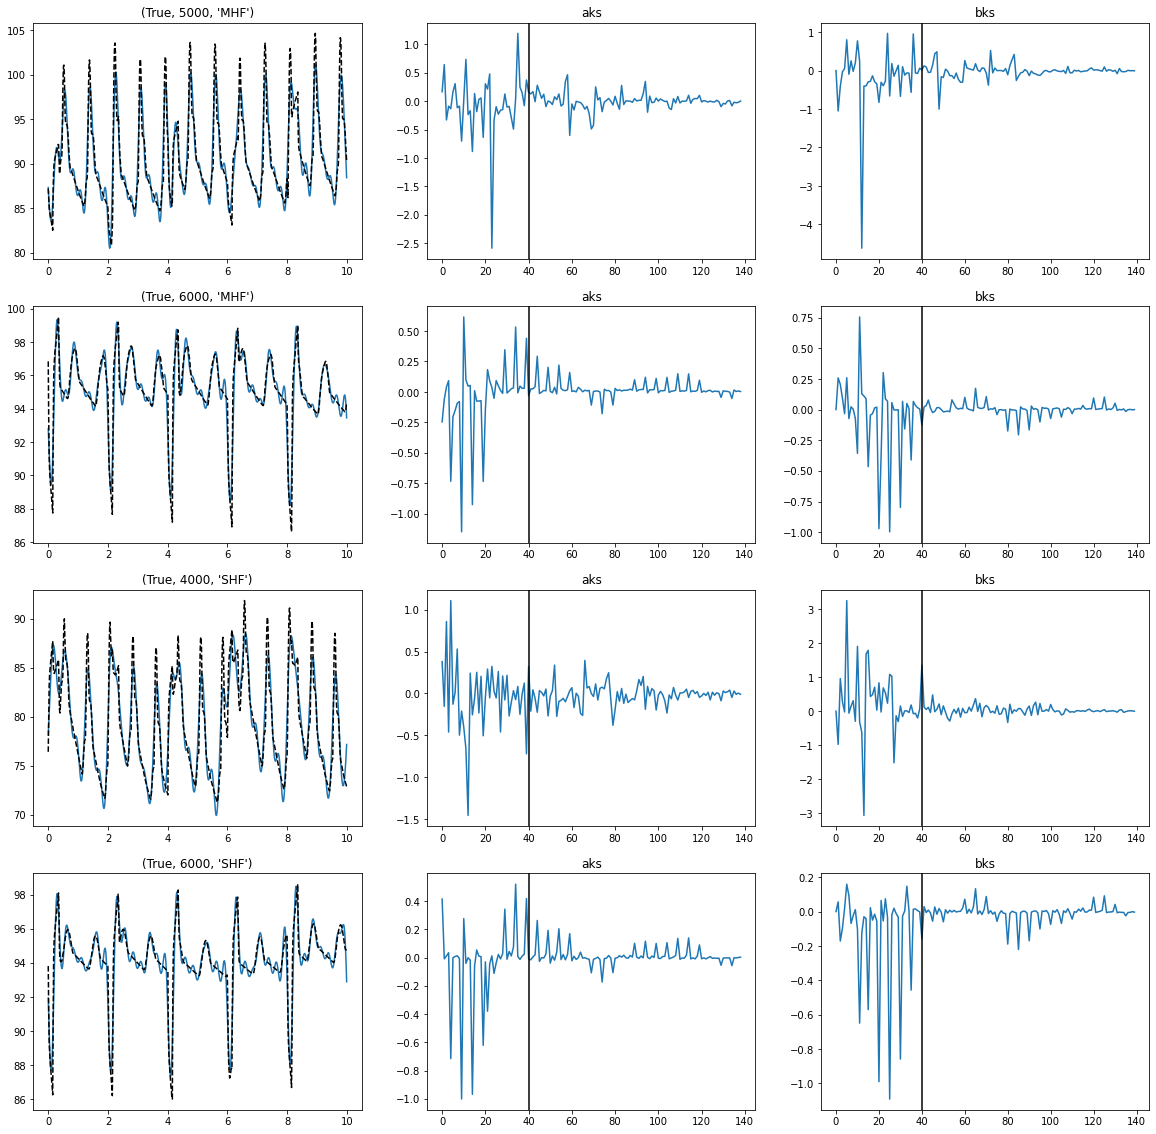

In [26]:
visualize(coefs,40)
plt.savefig('figs/fourier_overview.eps')

# Dicussion: number of Fourier coefficients

Choose the simulation configuration with the most perturbed arterial pressure signals, namely with severe heart failure @ 4000 RPM and with Artificial Pulse.

In [27]:
file = '/media/maousi/Data/tmp/case_study/Ursino1998Model_VAD2_AP_True_RPM_4000_HF_SHF.csv'

In [28]:
t, sap = extract_results(file, 'SystemicArteries.Inlet.P')
t, sap = sc.time_range(sap, t, 20.0, 30.0)
t_ = t

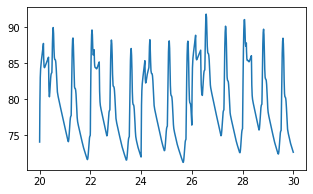

In [29]:
plt.subplots(figsize=(5,3))
plt.plot(t, sap);

In [30]:
_, aks, bks, T, t, signal = sc.perform_fft(sap, t, dt=0.015)

## Fourier coefficients plot

In [31]:
from ipypublish import nb_setup
plt = nb_setup.setup_matplotlib()
import seaborn as sns
sns.set(style='whitegrid')

In [32]:
ncoef_plot = 100

In [33]:
def plot_coefs(data, ids, ax, label):
    ax.plot(ids, data[ids])
    d = ax.scatter(ids, data[ids], color='k', zorder=3, s=6)
    ax.set_ylabel(label)

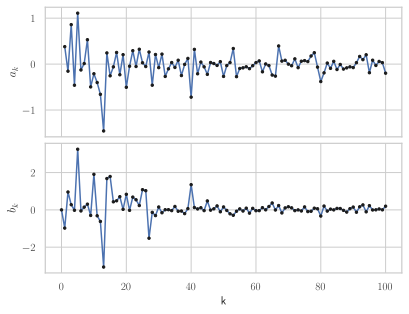

In [34]:
fig, ax = plt.subplots(2, 1, sharex=True)

k = range(1, ncoef_plot + 1)
plot_coefs(aks, k, ax[0], '$a_k$')
k = range(0, ncoef_plot + 1)
plot_coefs(bks, k, ax[1], '$b_k$')

# Cosmetics
plt.subplots_adjust(hspace=.05)
plt.xlabel('k');
plt.savefig('figs/fourier_coefs.eps')

## Reconstruction plots


In [35]:
ncoefs = [20, 40, 50]

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


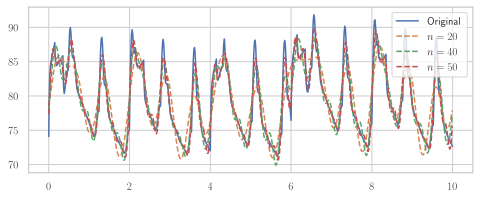

In [36]:
fig, ax = plt.subplots(figsize=(8,3))

# Original signal
plt.plot(t_ - min(t_), sap, label='Original')

# Reconstruct
for n in ncoefs:
    sap_tilde = reconstruct_truncated(n, aks, bks, t, T)
    plt.plot(t, sap_tilde, label=f'$n={n}$', ls='--')

plt.legend()
plt.savefig('figs/fourier_reconstruction_bad.eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


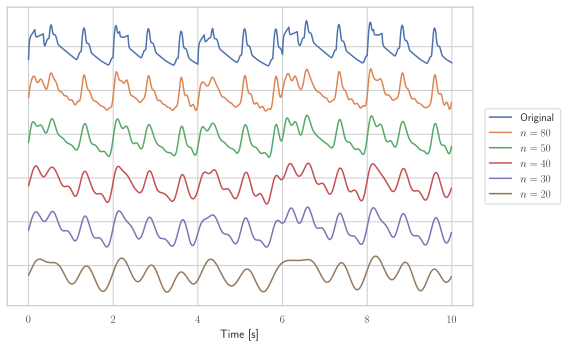

In [41]:
ncoefs = [20, 30, 40, 50, 80]
fig, ax = plt.subplots(figsize=(8,5))

# Original signal
plt.plot(t_ - min(t_), sap, label='Original')
max_amplitude = max(sap) - min(sap)

# Reconstruct
for i, n in enumerate(sorted(ncoefs, reverse=True)):
    sap_tilde = reconstruct_truncated(n, aks, bks, t, T)
    plt.plot(t, sap_tilde - (i+1)*max_amplitude, label=f'$n={n}$')

ax.set_yticklabels([])
plt.xlabel('Time [s]')
plt.legend(loc='center right', bbox_to_anchor=(1.2,.5));
plt.tight_layout()
plt.savefig('figs/fourier_reconstruction.eps', bbox_inches='tight')